## **Restore from Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp /content/drive/MyDrive/ECE-653/best_traffic_sign_model.pth .

In [3]:
!cp /content/drive/MyDrive/ECE-653/Dataset.zip . && unzip Dataset.zip && rm Dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/train/00007_00010_00023_png.rf.7835cbcfa6babb68c444a538b0062f17.jpg  
  inflating: Dataset/train/000010_jpg.rf.280eb2d57ed2f197721d34f6ca6c533e.jpg  
  inflating: Dataset/train/00000_00002_00010_png.rf.d57c8945142f6d675990162cdd0dec93.jpg  
  inflating: Dataset/train/000071_jpg.rf.8ebafdeafe82ad824de0313dfde2c888.jpg  
  inflating: Dataset/train/001466_jpg.rf.5f1e09ac149f516e67ac48f70c3b761d.jpg  
  inflating: Dataset/train/00007_00002_00010_png.rf.52a4637f1c61ee211104e9c6d1824d3b.jpg  
  inflating: Dataset/train/road426_png.rf.0cbcc9797ab58af5eefaeb13f28b0c30.jpg  
  inflating: Dataset/train/00000_00005_00002_png.rf.12521c166f3ca192f74ef5a18e5aa2cd.jpg  
  inflating: Dataset/train/001239_jpg.rf.26b4ca5e1f95a67cfe87a10160625899.jpg  
  inflating: Dataset/train/00008_00017_00023_png.rf.4e62fa0b1e9860ed7ef6fcb473637736.jpg  
  inflating: Dataset/train/road371_png.rf.a11017d6c00cd51171d171d53e204235.jpg  
  inflating:

In [4]:
!cp /content/drive/MyDrive/ECE-653/adv_samples_printed_and_pictured.zip . && unzip adv_samples_printed_and_pictured.zip && rm adv_samples_printed_and_pictured.zip

Streaming output truncated to the last 5000 lines.
  inflating: adv_samples_printed_and_pictured/iterative/adv_iterative_00003_00036_00028_png.rf.b3b837a4ff3803383e94a13fe8fc748b.jpg.png  
  inflating: __MACOSX/adv_samples_printed_and_pictured/iterative/._adv_iterative_00003_00036_00028_png.rf.b3b837a4ff3803383e94a13fe8fc748b.jpg.png  
  inflating: adv_samples_printed_and_pictured/iterative/adv_iterative_00005_00019_00027_png.rf.0b31410c63b73af7eb3a66a6a5069923.jpg.png  
  inflating: __MACOSX/adv_samples_printed_and_pictured/iterative/._adv_iterative_00005_00019_00027_png.rf.0b31410c63b73af7eb3a66a6a5069923.jpg.png  
  inflating: adv_samples_printed_and_pictured/iterative/adv_iterative_00008_00012_00009_png.rf.9403edeb2431ddaf3a85ad6f4eb028cf.jpg.png  
  inflating: __MACOSX/adv_samples_printed_and_pictured/iterative/._adv_iterative_00008_00012_00009_png.rf.9403edeb2431ddaf3a85ad6f4eb028cf.jpg.png  
  inflating: adv_samples_printed_and_pictured/iterative/adv_iterative_000182_jpg.rf.0e31

## **Import packages**

In [5]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import grad
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

from PIL import Image
from IPython.display import display
from google.colab.patches import cv2_imshow
from tqdm import tqdm

import os
import time
import random

## **Set to use CUDA**

In [6]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **Class Mapping**

In [7]:

class_to_idx = {
  'Speed Limit 10': 0,
  'Speed Limit 20': 1,
  'Speed Limit 30': 2,
  'Speed Limit 40': 3,
  'Speed Limit 50': 4,
  'Speed Limit 60': 5,
  'Speed Limit 70': 6,
  'Speed Limit 80': 7,
  'Speed Limit 90': 8,
  'Speed Limit 100': 9,
  'Speed Limit 110': 10,
  'Speed Limit 120': 11,
  'Stop': 12
}

class_names = {
    0: 'Speed Limit 10',
    1: 'Speed Limit 20',
    2: 'Speed Limit 30',
    3: 'Speed Limit 40',
    4: 'Speed Limit 50',
    5: 'Speed Limit 60',
    6: 'Speed Limit 70',
    7: 'Speed Limit 80',
    8: 'Speed Limit 90',
    9: 'Speed Limit 100',
    10: 'Speed Limit 110',
    11: 'Speed Limit 120',
    12: 'Stop'
}

## **Define our classifier**

In [8]:
IMAGE_SIZE = 64

class SimpleTrafficSignNet(nn.Module):
    def __init__(self, num_classes=13):
        super(SimpleTrafficSignNet, self).__init__()

        # Layer definitions
        self.conv1 = nn.Conv2d(3, IMAGE_SIZE, kernel_size=5, padding=2)
        self.dropout1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(IMAGE_SIZE, IMAGE_SIZE*2, kernel_size=5, padding=2)
        self.dropout2 = nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(IMAGE_SIZE*2, IMAGE_SIZE*4, kernel_size=5, padding=2)
        self.dropout3 = nn.Dropout(0.3)

        # This is the key part - we need separate pooling layers with specific sizes
        # to match the Keras model architecture exactly
        self.pool4 = nn.MaxPool2d(kernel_size=8, stride=8)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout4 = nn.Dropout(0.5)

        self.fc1 = nn.Linear(28672, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Conv1 path
        x1 = self.conv1(x)
        x1 = F.relu(x1)
        x1 = self.dropout1(x1)
        x1_pooled = self.pool(x1)

        # Conv2 path
        x2 = self.conv2(x1_pooled)
        x2 = F.relu(x2)
        x2 = self.dropout2(x2)
        x2_pooled = self.pool(x2)

        # Conv3 path
        x3 = self.conv3(x2_pooled)
        x3 = F.relu(x3)
        x3 = self.dropout3(x3)
        x3_pooled = self.pool(x3)

        # Multiscale pooling paths (matching Keras exactly)
        # Path 1: pool4 directly on conv1 output (after dropout)
        path1 = self.pool4(x1)

        # Path 2: pool5 on the output of pool2
        path2 = self.pool5(x2_pooled)

        # Path 3: already at the right size from pool3
        path3 = x3_pooled

        # Flatten and concatenate
        flat1 = torch.flatten(path1, 1)
        flat2 = torch.flatten(path2, 1)
        flat3 = torch.flatten(path3, 1)

        merged = torch.cat([flat1, flat2, flat3], dim=1)

        # Dense layers
        dense1 = self.fc1(merged)
        dense1 = F.relu(dense1)
        dense1 = self.dropout4(dense1)

        # Output layer (logits, no activation)
        output = self.fc2(dense1)         # num_classes

        return output

## **Define Inference**

In [9]:
def infer(model, cv_image):
    # Set model to evaluation mode
    cv2_image_rgb = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(cv2_image_rgb)
    transform = transforms.ToTensor()

    image_tensor = transform(image)
    image_tensor = image_tensor.permute(1, 2, 0)

    image_tensor = image_tensor.to(device)
    model = model.to(device)

    return predict(model, image_tensor)

# This predict function will be also used by adversarial attacks!
def predict(model, x_in):
    device = next(model.parameters()).device
    model.eval()

    with torch.no_grad():
        # Get current image dimensions
        h, w, c = x_in.shape

        # Convert numpy to tensor and add batch dimension
        x_tensor = x_in.clone().detach().permute(2, 0, 1).unsqueeze(0).to(device)
        #x_tensor = torch.tensor(x_in, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)

        if torch.any(x_tensor > 1.0):
            x_tensor = x_tensor / 255.0

        # Resize to model input size if needed
        if h != IMAGE_SIZE or w != IMAGE_SIZE:
            x_tensor = F.interpolate(x_tensor, size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False)

        outputs = model(x_tensor)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        prediction = outputs.argmax(dim=1).cpu().numpy()[0]


    return prediction, probabilities.squeeze().cpu().numpy()

def predict_class_only(model, x_in):
    prediction, _ = predict(model, x_in)
    return prediction

# Function to display prediction results
def display_prediction(predicted_class, probabilities):
    """
    Display the prediction results

    Args:
        predicted_class: Index of the predicted class
        probabilities: Probabilities for each class
    """
    print(f"Predicted class: {class_names[predicted_class]}")
    print(f"Confidence: {probabilities[predicted_class]*100:.2f}%")

    # Display top 3 predictions
    top3_indices = np.argsort(probabilities)[-3:][::-1]

    plt.figure(figsize=(10, 5))
    plt.barh([class_names[i] for i in top3_indices],
             [probabilities[i] for i in top3_indices])
    plt.xlabel('Probability')
    plt.title('Top 3 Predictions')
    plt.tight_layout()
    plt.show()

def perform_inference(model, cv_image, should_crop=False, display_pred=False):
    if should_crop:
      cv_image = crop_with_custom_model_cv2(cv_image)
      if cv_image is None:
          print("Nothing detected.")
          return None, None

    # Perform inference
    predicted_class, probabilities = infer(model, cv_image)

    if display_pred:
      display_prediction(predicted_class, probabilities)

    return predicted_class, probabilities

## **Load Model**

In [10]:
def load_model(model_path, num_classes=13):
    model = SimpleTrafficSignNet(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

model = load_model('best_traffic_sign_model.pth')

## **Train a Filter (with N*N sized kernel)**

In [12]:
FILTER_SIZE_1 = 7
FILTER_SIZE_2 = 5
low  = -0.1
high = 2.0


class AdversarialFilterTrainer:
    def __init__(self, model_path, initial_filter=None):
        """
        Initialize the filter trainer

        Args:
            model_path: Path to the pretrained classifier checkpoint
            initial_filter: Initial filter values (optional)
        """
        # Load the classifier model
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SimpleTrafficSignNet(num_classes=13)
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()  # Set to evaluation mode
        self.model.to(self.device)

        # Freeze the classifier model parameters
        for param in self.model.parameters():
            param.requires_grad = False

        filter_weights = (high - low) * torch.rand((FILTER_SIZE_1, FILTER_SIZE_1)) + low
        filter_weights = filter_weights / filter_weights.sum()
        initial_filter1 = filter_weights.unsqueeze(0).unsqueeze(0) # Convert to PyTorch parameter with correct shape for convolution
        initial_filter1 = initial_filter1.repeat(3, 1, 1, 1) # Expand to match input channels (3 for RGB)
        self.filter1 = nn.Parameter(initial_filter1.to(self.device)) # Create parameter and move to the same device as the model

        filter_weights = (high - low) * torch.rand((FILTER_SIZE_2, FILTER_SIZE_2)) + low
        filter_weights = filter_weights / filter_weights.sum()
        initial_filter2 = filter_weights.unsqueeze(0).unsqueeze(0) # Convert to PyTorch parameter with correct shape for convolution
        initial_filter2 = initial_filter2.repeat(3, 1, 1, 1) # Expand to match input channels (3 for RGB)
        self.filter2 = nn.Parameter(initial_filter2.to(self.device)) # Create parameter and move to the same device as the model

        # Define loss function and optimizer with higher learning rate
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam([self.filter1, self.filter2], lr=0.01)  # Increased from 0.001

    def apply_filter(self, images):
        # Ensure images are on the right device
        images = images.to(self.device)

        # Store original mean intensity per image and channel
        original_mean = images.mean(dim=[2, 3], keepdim=True)

        # Set padding for both filters
        padding1 = self.filter1.shape[2] // 2
        padding2 = self.filter2.shape[2] // 2

        # Apply first filter
        filtered_images = nn.functional.conv2d(
            images,
            self.filter1,
            padding=padding1,
            groups=3  # Apply the filter to each channel separately
        )

        # Apply second filter
        filtered_images = nn.functional.conv2d(
            filtered_images,
            self.filter2,
            padding=padding2,
            groups=3  # Apply the filter to each channel separately
        )

        # Calculate filtered image mean intensity
        filtered_mean = filtered_images.mean(dim=[2, 3], keepdim=True)

        # Adjust brightness to match original image mean intensity
        # Add small epsilon to avoid division by zero
        brightness_ratio = original_mean / (filtered_mean + 1e-10)
        filtered_images = filtered_images * brightness_ratio

        filtered_images = torch.clamp(filtered_images, 0, 255)

        return filtered_images

    def train_step(self, adv_images, orig_labels):
        """
        Perform one training step with batch support

        Args:
            adv_images: Batch of adversarial image tensors [batch_size, channels, height, width]
            orig_labels: Batch of original predicted labels [batch_size]

        Returns:
            loss: Training loss (mean across batch)
            recovered_probs: Probability of original labels after filtering (list for batch)
        """
        self.optimizer.zero_grad()

        # Get batch size
        batch_size = adv_images.size(0)

        # Apply the filter to the adversarial images
        filtered_images = self.apply_filter(adv_images)

        # Get model predictions
        logits = self.model(filtered_images)
        probs = torch.softmax(logits, dim=1)

        # Move labels to device if needed
        orig_labels = orig_labels.to(self.device)

        # Gather probabilities for the original labels using batch indexing
        # Creates a batch_size x 1 index tensor for gathering
        batch_indices = torch.arange(batch_size, device=self.device).unsqueeze(1)
        label_indices = orig_labels.unsqueeze(1)
        # Combine to create a batch_size x 2 index tensor
        indices = torch.cat([batch_indices, label_indices], dim=1)

        # Gather target probabilities - returns a tensor of shape [batch_size]
        target_probs = probs[indices[:, 0], indices[:, 1]]

        # Store target probabilities for each sample in batch for return
        recovered_probs = target_probs.detach().cpu().numpy().tolist()

        # 1. Direct maximization of target class probabilities (batch)
        direct_prob_loss = -torch.log(target_probs).mean()

        # 2. Classification cross-entropy loss (batch)
        ce_loss = self.criterion(logits, orig_labels)

        # 3. Margin loss - compute for the entire batch
        # Create mask to exclude target classes
        mask = torch.ones_like(probs, dtype=torch.bool)
        mask.scatter_(1, orig_labels.unsqueeze(1), False)

        # Get max probability across non-target classes for each sample
        # We use a large negative value to exclude target classes from the max operation
        other_probs = torch.where(mask, probs, torch.tensor(-1e10, device=self.device))
        max_other_probs = torch.max(other_probs, dim=1)[0]

        # Calculate margin loss for each sample
        margin_loss = torch.clamp(max_other_probs - target_probs + 0.2, min=0.0).mean()

        entropy_loss = -(probs * torch.log(probs + 1e-10)).sum(dim=1).mean()
        entropy_weight = 0.5

        # Combined loss
        loss = ce_loss + direct_prob_loss + margin_loss + entropy_weight * entropy_loss

        # Backpropagate and update filter parameters
        loss.backward()
        self.optimizer.step()

        # Force filter values to be non-negative and normalize
        with torch.no_grad():
            self.filter1.data.clamp_(low, high)
            self.filter2.data.clamp_(low, high)
            #self.filter1.data = self.filter1.data / self.filter1.data.sum()
            #self.filter2.data = self.filter2.data / self.filter2.data.sum()

        return loss.item(), recovered_probs

    def get_filter_numpy(self):
        """Get the trained filter as a numpy array"""
        with torch.no_grad():
            # Average across input channels to get a single 2D filter
            # This gives us a filter we can use with cv2.filter2D
            filter1_np = self.filter1.data.mean(dim=0).squeeze().cpu().numpy()
            filter2_np = self.filter2.data.mean(dim=0).squeeze().cpu().numpy()
            return filter1_np, filter2_np

    def save_filter(self, best):
        """Save the filter to a numpy file"""
        filter1_np, filter2_np = self.get_filter_numpy()
        if best:
            np.save('best_filter_1.npy', filter1_np)
            np.save('best_filter_2.npy', filter2_np)
        else:
            np.save('filter_1.npy', filter1_np)
            np.save('filter_2.npy', filter2_np)
        return filter1_np, filter2_np


class AdversarialDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Dataset for adversarial examples

        Args:
            csv_file: Path to the CSV file with annotations
            transform: Optional transform to be applied to images
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get file paths and labels
        adv_path = self.data.iloc[idx]['ADV_FILEPATH']
        orig_predicted_label = self.data.iloc[idx]['ORIG_PREDICTED_LABEL']

        # Load adversarial image
        adv_image = Image.open(adv_path).convert('RGB')

        # Apply transformations
        if self.transform:
            adv_image = self.transform(adv_image)

        return adv_image, orig_predicted_label


def train():
    # Set up data loading
    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Resize to match model input size
        transforms.ToTensor(),
    ])

    # Define batch size
    batch_size = 700

    # Create dataset and dataloader
    pd_dataset = pd.read_csv('adv_samples_printed_and_pictured/_annotations.csv')

    # Filter out JSMA and CW
    mask = pd_dataset['ATTACK_TYPE'].str.contains('jsma')
    selected_samples = pd_dataset[~mask].sort_values(by=['ORIGINAL_FILEPATH'])

    mask = selected_samples['ATTACK_TYPE'].str.contains('cw')
    selected_samples = selected_samples[~mask].sort_values(by=['ORIGINAL_FILEPATH'])

    mask = selected_samples['ATTACK_TYPE'].str.contains('fg')
    selected_samples = selected_samples[~mask].sort_values(by=['ORIGINAL_FILEPATH'])

    #selected_samples = pd_dataset

    train_size = int(0.9 * len(selected_samples))
    test_size = len(selected_samples) - train_size
    train_dataset, test_dataset = random_split(selected_samples, [train_size, test_size])

    test_indices = test_dataset.indices
    test_df = selected_samples.iloc[test_indices]
    test_df.to_csv('filter_test_dataset.csv', index=False)

    train_indices = train_dataset.indices
    train_df = selected_samples.iloc[train_indices]

    dataset = AdversarialDataset(
        data=train_df,
        transform=transform
    )

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize filter trainer with identity + noise initialization
    trainer = AdversarialFilterTrainer(
        model_path='best_traffic_sign_model.pth'
    )

    # Training loop
    num_epochs = 50
    best_avg_recovery = 0.0
    patience = 10  # Early stopping patience
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        epoch_losses = []
        epoch_recoveries = []

        for adv_images, orig_labels in dataloader:
            # Try several optimizer steps for each batch to push harder
            for _ in range(3):  # Multiple optimization steps per batch
                loss, recovered_probs = trainer.train_step(adv_images, orig_labels)

            epoch_losses.append(loss)
            # Add all recoveries from the batch to the list
            epoch_recoveries.extend(recovered_probs)

        # Calculate average metrics
        avg_loss = sum(epoch_losses) / len(epoch_losses)
        avg_recovery = sum(epoch_recoveries) / len(epoch_recoveries)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Avg Recovery Prob: {avg_recovery:.4f}")

        trainer.save_filter(best=False)
        # Save best filter
        if avg_recovery > best_avg_recovery:
            best_avg_recovery = avg_recovery
            trainer.save_filter(best=True)
            print(f"New best filter saved with recovery probability: {avg_recovery:.4f}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        """
        # Early stopping check
        if epochs_no_improve >= patience:
            print(f"Early stopping after {epoch+1} epochs without improvement")
            break
        """

        # Learning rate schedule - reduce learning rate if no improvement
        if epochs_no_improve > 0 and epochs_no_improve % 10 == 0:
            for param_group in trainer.optimizer.param_groups:
                param_group['lr'] *= 0.5
                print(f"Reduced learning rate to {param_group['lr']}")


    # Print the final trained filter
    best_filter_1, best_filter_2 = trainer.get_filter_numpy()
    print(best_filter_1)
    print(best_filter_2)

train()

Epoch 1/50, Loss: 3.4272, Avg Recovery Prob: 0.4314
New best filter saved with recovery probability: 0.4314
Epoch 2/50, Loss: 3.0835, Avg Recovery Prob: 0.4824
New best filter saved with recovery probability: 0.4824
Epoch 3/50, Loss: 2.9257, Avg Recovery Prob: 0.4973
New best filter saved with recovery probability: 0.4973
Epoch 4/50, Loss: 2.9384, Avg Recovery Prob: 0.5124
New best filter saved with recovery probability: 0.5124
Epoch 5/50, Loss: 2.9152, Avg Recovery Prob: 0.5013
Epoch 6/50, Loss: 2.8872, Avg Recovery Prob: 0.5137
New best filter saved with recovery probability: 0.5137
Epoch 7/50, Loss: 2.8277, Avg Recovery Prob: 0.5243
New best filter saved with recovery probability: 0.5243
Epoch 8/50, Loss: 2.9573, Avg Recovery Prob: 0.5017
Epoch 9/50, Loss: 2.7417, Avg Recovery Prob: 0.5241
Epoch 10/50, Loss: 2.9183, Avg Recovery Prob: 0.5057
Epoch 11/50, Loss: 3.3775, Avg Recovery Prob: 0.4335
Epoch 12/50, Loss: 3.3985, Avg Recovery Prob: 0.4448
Epoch 13/50, Loss: 3.2769, Avg Recove

KeyboardInterrupt: 

In [18]:
name = '0422'

In [19]:
!zip {name}.zip best_filter_1.npy best_filter_2.npy && cp {name}.zip drive/MyDrive/ECE-653/{name}.zip

  adding: best_filter_1.npy (deflated 15%)
  adding: best_filter_2.npy (deflated 23%)


In [20]:
!cp filter_test_dataset.csv drive/MyDrive/ECE-653/filter_test_dataset.csv

## **Define BGR2RGB**

In [16]:
def rgb(cv_image):
  temp = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
  return temp

## APPLY A FILTER!** (Programmatically)

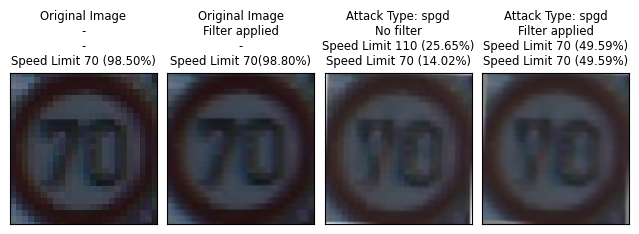

In [17]:
filter1 = np.load('best_filter_1.npy')
filter2 = np.load('best_filter_2.npy')

df = pd.read_csv("filter_test_dataset.csv", header=0)

images = [11]
for image in images:
    mask = df['ATTACK_TYPE'].str.contains('spgd')
    selected_sample = df[mask].sort_values(by=['ORIGINAL_FILEPATH']).iloc[image]

    sample_orig_path = selected_sample.iloc[0]
    sample_orig_cv2_image = cv2.imread(sample_orig_path)
    sample_orig_pred_label = selected_sample.iloc[5]
    sample_orig_pred_prob = selected_sample.iloc[6]

    sample_orig_cv2_filtered_image = sample_orig_cv2_image.copy()
    original_mean = np.mean(sample_orig_cv2_filtered_image, axis=(0, 1), keepdims=True)
    orig_filtered_image = cv2.filter2D(sample_orig_cv2_filtered_image, -1, filter1, borderType=cv2.BORDER_REFLECT)
    orig_filtered_image = cv2.filter2D(orig_filtered_image, -1, filter2, borderType=cv2.BORDER_REFLECT)
    filtered_mean = np.mean(orig_filtered_image, axis=(0, 1), keepdims=True)
    brightness_ratio = original_mean / (filtered_mean + 1e-10)
    orig_filtered_image = orig_filtered_image * brightness_ratio
    orig_filtered_image = np.clip(orig_filtered_image, 0, 255).astype(np.uint8)
    orig_filtered_label, orig_filtered_prob = infer(model, orig_filtered_image)


    sample_adv_path = selected_sample.iloc[1]
    sample_adv_cv2_image = cv2.imread(sample_adv_path)

    original_mean = np.mean(sample_adv_cv2_image, axis=(0, 1), keepdims=True)
    filtered_image = cv2.filter2D(sample_adv_cv2_image, -1, filter1, borderType=cv2.BORDER_REFLECT)
    filtered_image = cv2.filter2D(filtered_image, -1, filter2, borderType=cv2.BORDER_REFLECT)
    filtered_mean = np.mean(filtered_image, axis=(0, 1), keepdims=True)
    brightness_ratio = original_mean / (filtered_mean + 1e-10)
    filtered_image = filtered_image * brightness_ratio
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)
    sample_filtered_pred_label, sample_filtered_pred_prob = infer(model, filtered_image)

    plt.rcParams.update({'font.size': 7})
    fig, axes = plt.subplots(1, 4)
    axes = axes.flatten()
    for i, ax in enumerate(axes):
      ax.set_xticks([])  # Remove x-axis ticks
      ax.set_yticks([])  # Remove y-axis ticks

    # Display each image in a subplot

    axes[0].imshow(rgb(sample_orig_cv2_image), interpolation='nearest')
    axes[0].set_title(f'Original Image\n-\n-\n{class_names[selected_sample.iloc[5]]} ({selected_sample.iloc[6] * 100:.2f}%)')

    axes[1].imshow(rgb(orig_filtered_image), interpolation='nearest')
    axes[1].set_title(f'Original Image\nFilter applied\n-\n{class_names[orig_filtered_label]}({orig_filtered_prob[orig_filtered_label] * 100:.2f}%)')

    axes[2].imshow(rgb(sample_adv_cv2_image))
    axes[2].set_title(f'Attack Type: {selected_sample.iloc[2]}\nNo filter\n{class_names[selected_sample.iloc[7]]} ({selected_sample.iloc[8] * 100:.2f}%)\n{class_names[sample_orig_pred_label]} ({selected_sample.iloc[9] * 100:.2f}%)')

    axes[3].imshow(rgb(filtered_image))
    axes[3].set_title(f'Attack Type: {selected_sample.iloc[2]}\nFilter applied\n{class_names[sample_filtered_pred_label]} ({sample_filtered_pred_prob[sample_filtered_pred_label] * 100:.2f}%)\n{class_names[sample_orig_pred_label]} ({sample_filtered_pred_prob[sample_orig_pred_label] * 100:.2f}%)')

    plt.tight_layout()
    plt.show()
    print('\n\n')
